# Test of SNN for Gesture Detection

## Imports

In [1]:
# SNN
import tonic
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils

# Visualization
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Misc
import numpy as np
import numpy.lib.recfunctions as rf

# Core
import os

## Load Dataset Using Tonic

In [2]:
# Get the path to this file and create a data directory
data_path = os.path.join(os.getcwd(), "data")
os.makedirs(data_path, exist_ok=True)

# Load the dataset using Tonic
train = tonic.datasets.DVSGesture(save_to=data_path, train=True)
test = tonic.datasets.DVSGesture(save_to=data_path, train=False)

## Event Extraction

Each set in the dataset contains a series of `events`. An event consists of a XY-coordinate that either increased or decreases in intensity depending on the polarity. The timestamps are the time the event occured in ms.

### Labels
For some reason the labels from the dataset csv are _not_ zero-indexed. Beware.

- **1**: hand_clapping
- **2**: right_hand_wave
- **3**: left_hand_wave
- **4**: right_hand_clockwise
- **5**: right_hand_counter_clockwise
- **6**: left_hand_clockwise
- **7**: left_hand_counter_clockwise
- **8**: forearm_roll_forward
- **8**: forearm_roll_backward
- **9**: drums
- **10**: guitar
- **11**: random_other_gestures

In [3]:
events, label = train[0]

timestamps = events['t']
x_coords = events['x']
y_coords = events['y']
polarities = events['p']

cut = 5
print("Timestamps:", timestamps[:cut])
print("X-coordinates:", x_coords[:cut])
print("Y-coordinates:", y_coords[:cut])
print("Polarities:", polarities[:cut])
print("Label:", label+1) # +1 because the labels are 0-indexed

Timestamps: [28 38 39 39 65]
X-coordinates: [49 55 55 55 90]
Y-coordinates: [82 92 92 92 99]
Polarities: [False  True  True  True False]
Label: 1


## Accumulate All Events and Plot

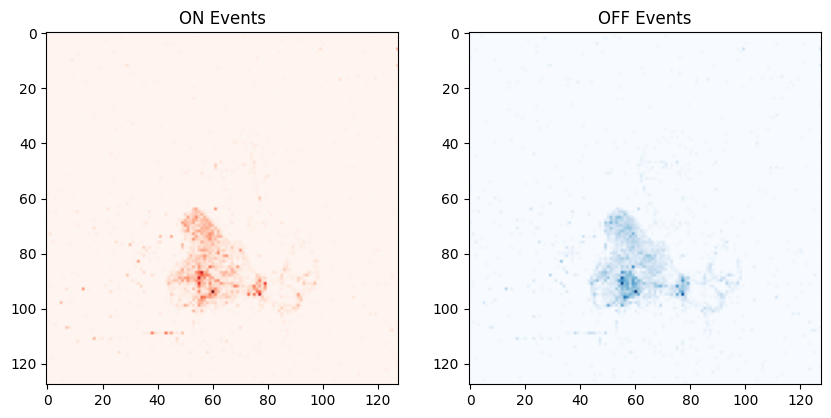

In [4]:
sensor_size = (128, 128)  # Assuming a 64x128 sensor

# Create empty images for ON and OFF events
on_event_image = np.zeros(sensor_size)
off_event_image = np.zeros(sensor_size)

num_events = 10000
for i in range(num_events):
    x, y, p = x_coords[i], y_coords[i], polarities[i]
    if p:
        on_event_image[y, x] += 1
    else:
        off_event_image[y, x] += 1

# Plot the accumulated event frames
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(on_event_image, cmap="Reds")
ax[0].set_title("ON Events")

ax[1].imshow(off_event_image, cmap="Blues")
ax[1].set_title("OFF Events")

plt.show()

## Animation
Bootleg way to animate the events.

Events are binned by time and a frame is generated and saved in `./frames`.

In [5]:
def to_us(seconds):
    """
    Converts seconds to microseconds.
    """
    return seconds * 1e6

def create_frames_dir() -> str:
    """
    Create the frames directory and clean it if it exists.
    """
    data_path = os.path.join(os.getcwd(), "frames")
    if os.path.exists(data_path):
        for file in os.listdir(data_path):
            file_path = os.path.join(data_path, file)
            if os.path.isfile(file_path):
                os.unlink(file_path)
    else:
        os.makedirs(data_path, exist_ok=True)
    return data_path

def time_bin_frames(events, sensor_size, time_bin) -> None:
    """
    Accumulates events in time bins and saves them as frames.

    Args:
        events: The events dictionary.
        time_bin: The time bin in microseconds.
    """
    timestamps = events['t']
    x_coords = events['x']
    y_coords = events['y']
    polarities = events['p']

    frame_path = create_frames_dir()

    on_event_image = np.zeros(sensor_size)
    off_event_image = np.zeros(sensor_size)
    time = time_bin
    for i, (x, y, p) in enumerate(zip(x_coords, y_coords, polarities)):
        on_event_image[y, x] += p
        off_event_image[y, x] += 1 - p
        if timestamps[i] >= time:
            total_events = on_event_image + off_event_image
            plt.imsave(os.path.join(frame_path, f"frame_{time*1e-3}ms.png"), total_events, cmap="Reds")
            on_event_image = np.zeros(sensor_size)
            off_event_image = np.zeros(sensor_size)
            time += time_bin

def frames_to_video(time_bin, frame_dir="./frames") -> HTML:
    """
    Converts the frames to a video.
    """
    frame_dir = "./frames"
    # List images and sort them correctly. This is an absolutely disgusting solution.
    images = sorted(
        [image for image in os.listdir(frame_dir) if image.endswith(".png")],
        key=lambda x: int("".join(filter(str.isdigit, x)))
    )
    images = [os.path.join(frame_dir, image) for image in images]

    fig, ax = plt.subplots()
    ax.axis("off")

    img = plt.imread(images[0])
    im = ax.imshow(img, animated=True)

    def update(frame):
        im.set_array(plt.imread(images[frame]))
        return [im]

    anim = animation.FuncAnimation(fig, update, frames=len(images), interval=time_bin*1e-3, blit=True)
    video = HTML(anim.to_html5_video())
    plt.close()
    return video

In [6]:
events, label = train[0]
time_bin_frames(events, (128, 128), to_us(0.05))
frames_to_video(to_us(0.05))

## Data Processing for Training

In [7]:
w, h = 32, 32
n_frames = 32
debug = False

# Denoise: Removes outlier events with inactive surrounding pixels for 10ms
# Downsample: Downsamples the image to 32x32
# ToFrame: Converts the events to n_frames frames per trail
transforms = tonic.transforms.Compose([
    tonic.transforms.Denoise(filter_time=10000),
    tonic.transforms.Downsample(sensor_size=tonic.datasets.DVSGesture.sensor_size, target_size=(w,h)),
])

data_path = os.path.join(os.getcwd(), "data")
os.makedirs(data_path, exist_ok=True)

train2 = tonic.datasets.DVSGesture(save_to=data_path, transform=transforms, train=True)
test2 = tonic.datasets.DVSGesture(save_to=data_path, transform=transforms, train=False)

cache_path = os.path.join(os.getcwd(), "./data/cache")
os.makedirs(cache_path, exist_ok=True)

events, label = train2[0]
time_bin_frames(events, (w, h), to_us(0.05))
frames_to_video(to_us(0.05))

## Net Definition

In [10]:
device = (
    "cuda" if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

grad = snn.surrogate.fast_sigmoid(slope=25) # surrogate.atan()
beta = 0.5

# 12C5-MP2-32C5-MP2-800FC11 https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_7.html
net = nn.Sequential(
    nn.Conv2d(2, 12, 5), # in_channels, out_channels, kernel_size
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=grad, init_hidden=True),
    nn.Conv2d(12, 32, 5),
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=grad, init_hidden=True),
    nn.Flatten(),
    nn.Linear(800, 11), #800
    snn.Leaky(beta=beta, spike_grad=grad, init_hidden=True, output=True)
).to(device)

def forward_pass(net, data):
    spk_rec = []
    snn.utils.reset(net)  # resets hidden states for all LIF neurons in net
    for step in range(data.size(0)): # data.size(0) = number of time steps
        spk_out, mem_out = net(data[step])
        spk_rec.append(spk_out)
    return torch.stack(spk_rec)

optimizer = torch.optim.Adam(net.parameters(), lr=0.002, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

Using cuda device


## Train

In [ ]:
import time

w, h = 32, 32
n_frames = 32
debug = False

# Denoise: Removes outlier events with inactive surrounding pixels for 10ms
# Downsample: Downsamples the image to 32x32
# ToFrame: Converts the events to n_frames frames per trail
transforms = tonic.transforms.Compose([
    tonic.transforms.Denoise(filter_time=10000),
    tonic.transforms.Downsample(sensor_size=tonic.datasets.DVSGesture.sensor_size, target_size=(w,h)),
    tonic.transforms.ToFrame(sensor_size=(w,h,2), n_time_bins=n_frames),
])

data_path = os.path.join(os.getcwd(), "data")
os.makedirs(data_path, exist_ok=True)

train3 = tonic.datasets.DVSGesture(save_to=data_path, transform=transforms, train=True)
test3 = tonic.datasets.DVSGesture(save_to=data_path, transform=transforms, train=False)

cache_path = os.path.join(os.getcwd(), "./data/cache")
os.makedirs(cache_path, exist_ok=True)
cached_train = train3 if debug else tonic.DiskCachedDataset(train3, cache_path=cache_path)
cached_test = test3 if debug else tonic.DiskCachedDataset(test3, cache_path=cache_path)

train_loader = torch.utils.data.DataLoader(
    cached_train, batch_size=64, shuffle=True, drop_last=True,
    num_workers=8,
    pin_memory=True,
    prefetch_factor=4,
    persistent_workers=True,
    collate_fn=tonic.collation.PadTensors(batch_first=False)
    )
test_loader = torch.utils.data.DataLoader(
    cached_test, batch_size=32, shuffle=True, drop_last=True,
    collate_fn=tonic.collation.PadTensors(batch_first=False)
    )

loss_hist     = []
acc_hist      = []
test_acc_hist = []

num_epochs = 100
cnt = 0

def validate_model():
    correct, total = 0, 0  
    for batch, (data, targets) in enumerate(iter(test_loader)): 
        data, targets = data.to(device), targets.to(device) # [n_frames, batch, polarity, x-pos, y-pos] [batch] 
        spk_rec = forward_pass(net, data)         
        correct += SF.accuracy_rate(spk_rec, targets) * data.shape[0]
        total += data.shape[0]
    return correct/total

t0 = time.time()
for epoch in range(num_epochs):
    for batch, (data, targets) in enumerate(iter(train_loader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        # propagating one batch through the network and evaluating loss
        spk_rec = forward_pass(net, data)
        loss = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss.item())

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)

        if cnt % 50 == 0:
            print(f"Epoch {epoch}, Iteration {batch} \nTrain Loss: {loss.item():.2f}")
            print(f"Train Accuracy: {acc * 100:.2f}%")
            test_acc = validate_model()            
            test_acc_hist.append(test_acc)
            print(f"Test Accuracy: {test_acc * 100:.2f}%\n")

        cnt+=1

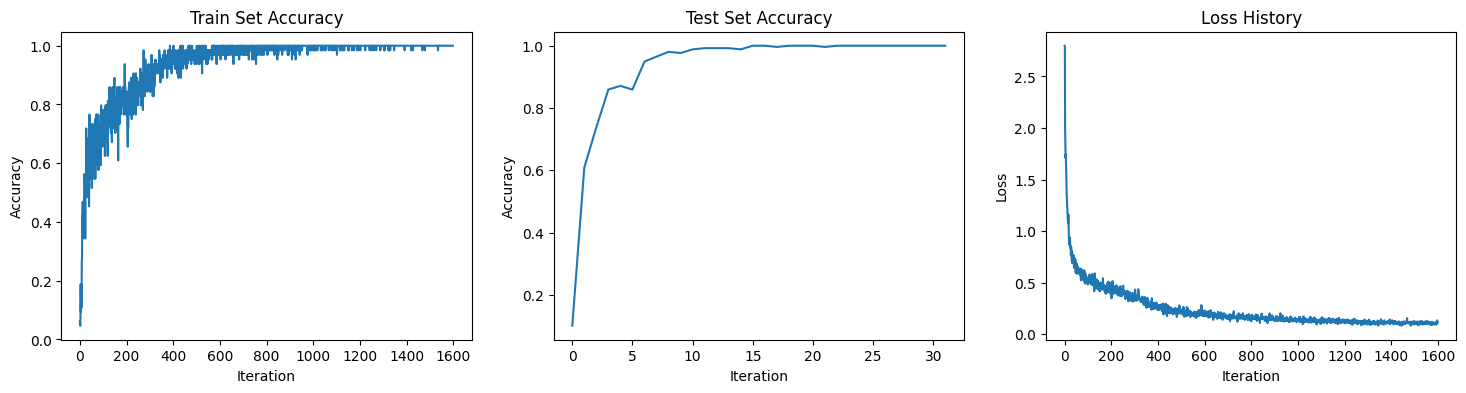

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18,4))

# Plot Train Accuracy
axes[0].plot(acc_hist)
axes[0].set_title("Train Set Accuracy")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Accuracy")

# Plot Test Accuracy
axes[1].plot(test_acc_hist)
axes[1].set_title("Test Set Accuracy")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Accuracy")

# Plot Training Loss
axes[2].plot(loss_hist)
axes[2].set_title("Loss History")
axes[2].set_xlabel("Iteration")
axes[2].set_ylabel("Loss")

plt.show()